In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

LABEL2ID = {"ENHANCER": 0, "PROMOTER": 1, "OCR": 2, "REGULATORY": 3}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}
LABEL_MAP = ["ENHANCER", "PROMOTER", "OCR", "REGULATORY"]

In [10]:
def load_and_analyze(parquet_path):
    print("--- Loading Data ---")
    df = pd.read_parquet(parquet_path)
    
    X = df['sequence'].tolist()
    y = df['label'].values
    
    lengths = [len(s) for s in X]
    limit_95 = int(np.percentile(lengths, 95)) # אורך שמכסה 95% מהדאטה
    print(f"Average Length: {np.mean(lengths):.2f}")
    print(f"Max Length in data: {max(lengths)}")
    print(f"95th Percentile Length: {limit_95} (Recommended for CNN padding)")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, limit_95


path = './unified_genomic_dataset/genomic_multiclass_balanced.parquet'
X_train, X_test, y_train, y_test, RECOMMENDED_LEN = load_and_analyze(path)

--- Loading Data ---
Average Length: 282.03
Max Length in data: 593
95th Percentile Length: 479 (Recommended for CNN padding)
Train size: 86714, Test size: 21679


In [ ]:
print("\n--- Step 2: SVM Optimization with Optuna ---")

subset_idx = np.random.choice(len(X_train), size=15000, replace=False)
X_train_sub = [X_train[i] for i in subset_idx]
y_train_sub = y_train[subset_idx]

def objective(trial):
    k_mer = trial.suggest_int('k_mer', 3, 6) # גודל ה-K-mer
    c_param = trial.suggest_float('C', 1e-3, 10, log=True) # רגולריזציה
    
    # K-mer
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k_mer, k_mer))
    X_vec = vectorizer.fit_transform(X_train_sub)
    
    # Validation
    X_tr, X_val, y_tr, y_val = train_test_split(X_vec, y_train_sub, test_size=0.25, random_state=42)
    
    # LinearSVC
    clf = LinearSVC(C=c_param, dual=False, max_iter=2000)
    clf.fit(X_tr, y_tr)
    
    return clf.score(X_val, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15) # מריץ 15 ניסויים

print(f"Best Params: {study.best_params}")

print("\nTraining Final SVM on FULL dataset...")
best_k = study.best_params['k_mer']
best_c = study.best_params['C']

# וקטוריזציה
final_vec = CountVectorizer(analyzer='char', ngram_range=(best_k, best_k))
X_train_svm = final_vec.fit_transform(X_train)
X_test_svm = final_vec.transform(X_test)

svm_model = LinearSVC(C=best_c, dual=False, verbose=1)
svm_model.fit(X_train_svm, y_train)

y_pred_svm = svm_model.predict(X_test_svm)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Final Accuracy: {acc_svm:.4f}")

[I 2026-01-06 18:01:47,080] A new study created in memory with name: no-name-03d00acd-5eeb-4bea-94c0-8b9c29b72c1d



--- Step 2: SVM Optimization with Optuna ---


[I 2026-01-06 18:02:00,314] Trial 0 finished with value: 0.5624 and parameters: {'k_mer': 5, 'C': 0.4212224730408994}. Best is trial 0 with value: 0.5624.
[I 2026-01-06 18:02:01,586] Trial 1 finished with value: 0.5618666666666666 and parameters: {'k_mer': 3, 'C': 0.004165252432469897}. Best is trial 0 with value: 0.5624.
[I 2026-01-06 18:02:04,993] Trial 2 finished with value: 0.5552 and parameters: {'k_mer': 5, 'C': 0.005816900357055158}. Best is trial 0 with value: 0.5624.
[I 2026-01-06 18:02:34,897] Trial 3 finished with value: 0.5376 and parameters: {'k_mer': 6, 'C': 0.6873333513437329}. Best is trial 0 with value: 0.5624.
[I 2026-01-06 18:02:48,635] Trial 4 finished with value: 0.5426666666666666 and parameters: {'k_mer': 6, 'C': 0.28338041028339017}. Best is trial 0 with value: 0.5624.
[I 2026-01-06 18:03:04,029] Trial 5 finished with value: 0.5616 and parameters: {'k_mer': 5, 'C': 1.1415474040050237}. Best is trial 0 with value: 0.5624.
[I 2026-01-06 18:03:07,493] Trial 6 finis

Best Params: {'k_mer': 6, 'C': 0.0012868056953809221}

Training Final SVM on FULL dataset...
[LibLinear]iter  1 act 2.025e+01 pre 1.991e+01 delta 1.592e-01 f 1.116e+02 |g| 4.247e+02 CG   3
cg reaches trust region boundary
iter  2 act 2.350e+00 pre 2.557e+00 delta 1.692e-01 f 9.134e+01 |g| 3.601e+01 CG   4
cg reaches trust region boundary
iter  3 act 2.219e+00 pre 2.215e+00 delta 1.956e-01 f 8.899e+01 |g| 5.281e+01 CG   5
cg reaches trust region boundary
iter  4 act 1.365e+00 pre 1.488e+00 delta 2.183e-01 f 8.677e+01 |g| 2.359e+01 CG   5
cg reaches trust region boundary
iter  5 act 9.175e-01 pre 9.116e-01 delta 2.358e-01 f 8.541e+01 |g| 1.872e+01 CG   6
cg reaches trust region boundary
iter  6 act 6.222e-01 pre 6.085e-01 delta 2.549e-01 f 8.449e+01 |g| 1.312e+01 CG   8
cg reaches trust region boundary
iter  7 act 3.463e-01 pre 3.470e-01 delta 2.675e-01 f 8.387e+01 |g| 7.902e+00 CG  11
cg reaches trust region boundary
iter  8 act 2.144e-01 pre 2.144e-01 delta 2.815e-01 f 8.352e+01 |g| 3.

In [12]:
DNA_DICT = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4} 

def encode_and_pad(sequences, max_len):
    encoded_list = []
    for seq in sequences:
        # המרה למספרים, תווים לא מוכרים יקבלו 4
        num_seq = [DNA_DICT.get(base, 4) for base in seq] 
        encoded_list.append(num_seq)
    
    # Padding
    return pad_sequences(encoded_list, maxlen=max_len, padding='post', truncating='post', value=4)

# הכנת הדאטה לרשת
FINAL_LEN = max(RECOMMENDED_LEN, 200) 
print(f"Encoding sequences with Max Length: {FINAL_LEN}")

X_train_cnn = encode_and_pad(X_train, FINAL_LEN)
X_test_cnn = encode_and_pad(X_test, FINAL_LEN)

# הופכים ל-One Hot בערוצים (Channels)
# קלט: (samples, length) -> פלט: (samples, length, 5)
X_train_cnn_ohe = tf.keras.utils.to_categorical(X_train_cnn, num_classes=5)
X_test_cnn_ohe = tf.keras.utils.to_categorical(X_test_cnn, num_classes=5)


Encoding sequences with Max Length: 479


In [ ]:
Strides
def build_dna_cnn(seq_length, num_classes=4):
    """
    Build 1D-CNN for DNA sequence classification
    
    Args:
        seq_length: Length of padded sequences (FINAL_LEN)
        num_classes: Number of output classes (4 for your case)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # First Conv Block
        layers.Conv1D(filters=128, kernel_size=12, activation='relu', 
                     input_shape=(seq_length, 5)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        layers.Dropout(0.2),
        
        # Second Conv Block
        layers.Conv1D(filters=256, kernel_size=8, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        layers.Dropout(0.3),
        
        # Third Conv Block
        layers.Conv1D(filters=128, kernel_size=6, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(multi_label=False, name='auc')]
    )
    
    return model

In [14]:
model = build_dna_cnn(seq_length=FINAL_LEN, num_classes=4)
model.summary()

# Convert labels to categorical (if not already done)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X_train_cnn_ohe, y_train_cat,
    validation_split=0.15,
    epochs=20,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 468, 128)       │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 468, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 117, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 117, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 110, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 110, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 22, 128)        │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 847,428 (3.23 MB)

 Trainable params: 845,892 (3.23 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 768ms/step - accuracy: 0.6218 - auc: 0.8628 - loss: 0.9877 - val_accuracy: 0.3322 - val_auc: 0.5548 - val_loss: 7.1119 - learning_rate: 0.0010
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 124s 864ms/step - accuracy: 0.7204 - auc: 0.9422 - loss: 0.4753 - val_accuracy: 0.3322 - val_auc: 0.5767 - val_loss: 4.6153 - learning_rate: 0.0010
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7307 - auc: 0.9462 - loss: 0.4531 - val_accuracy: 0.5979 - val_auc: 0.8930 - val_loss: 0.7711 - learning_rate: 0.0010
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.7331 - auc: 0.9477 - loss: 0.4431 - val_accuracy: 0.7243 - val_auc: 0.9445 - val_loss: 0.4449 - learning_rate: 0.0010
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.7376 - auc: 0.9480 - loss: 0.4435 - val_accuracy: 0.7389 - val_auc: 0.9490 - val_loss: 0.4384 - learning_rate: 0.0010
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.74

678/678 ━━━━━━━━━━━━━━━━━━━━ 312s 461ms/step - accuracy: 0.7804 - auc: 0.9604 - loss: 0.4067

Test Accuracy: 0.7824
Test AUC: 0.9609
678/678 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


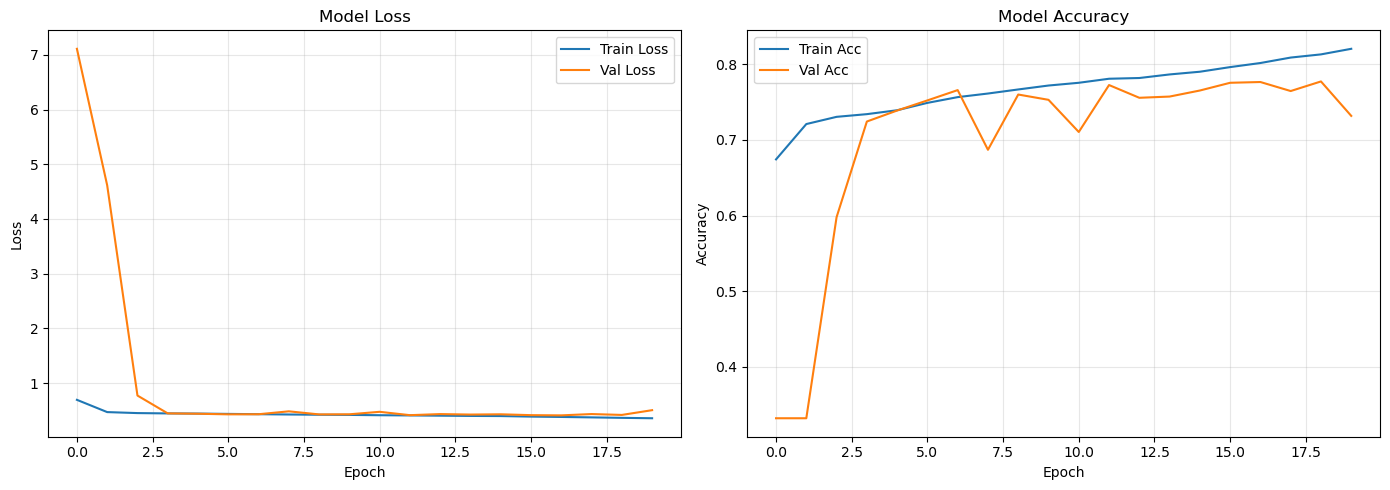


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65      7226
           1       0.99      1.00      1.00      7226
           2       0.65      0.75      0.70      7227

    accuracy                           0.78     21679
   macro avg       0.79      0.78      0.78     21679
weighted avg       0.79      0.78      0.78     21679



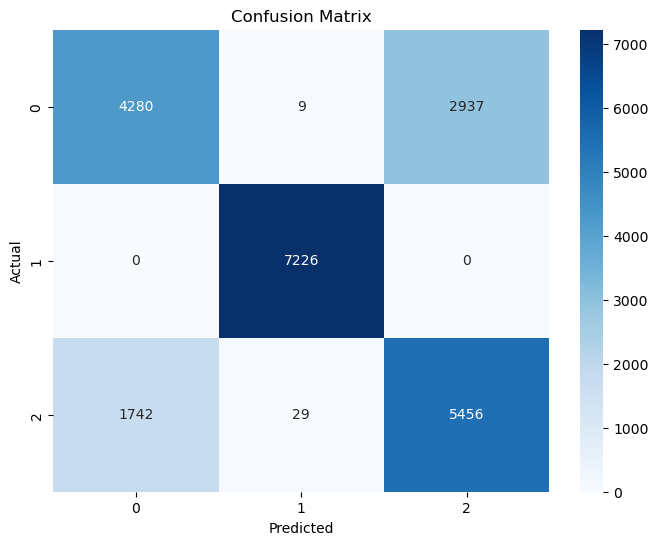

In [15]:
test_loss, test_acc, test_auc = model.evaluate(X_test_cnn_ohe, y_test_cat)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Make predictions
predictions = model.predict(X_test_cnn_ohe)
predicted_classes = predictions.argmax(axis=1)

# Optional: Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], label='Train Acc')
ax2.plot(history.history['val_accuracy'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_test_classes = y_test_cat.argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_test_classes, predicted_classes))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


--- Step 4: Final Evaluation ---
678/678 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


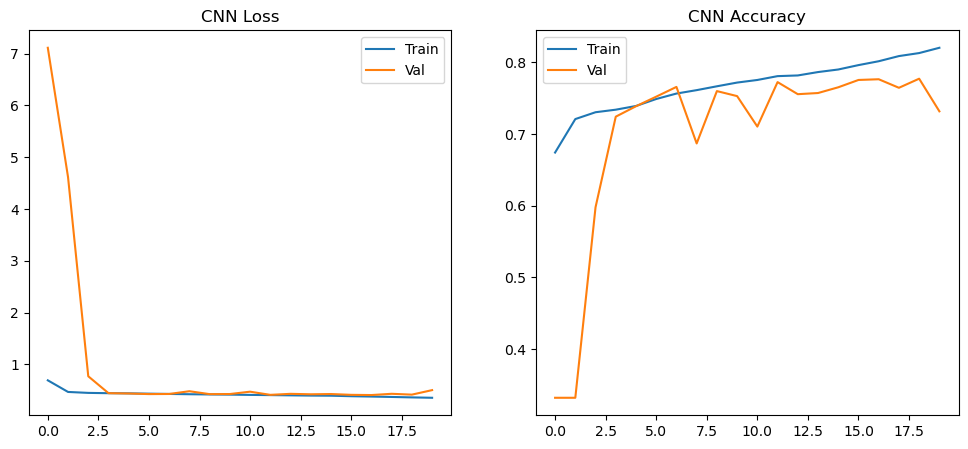

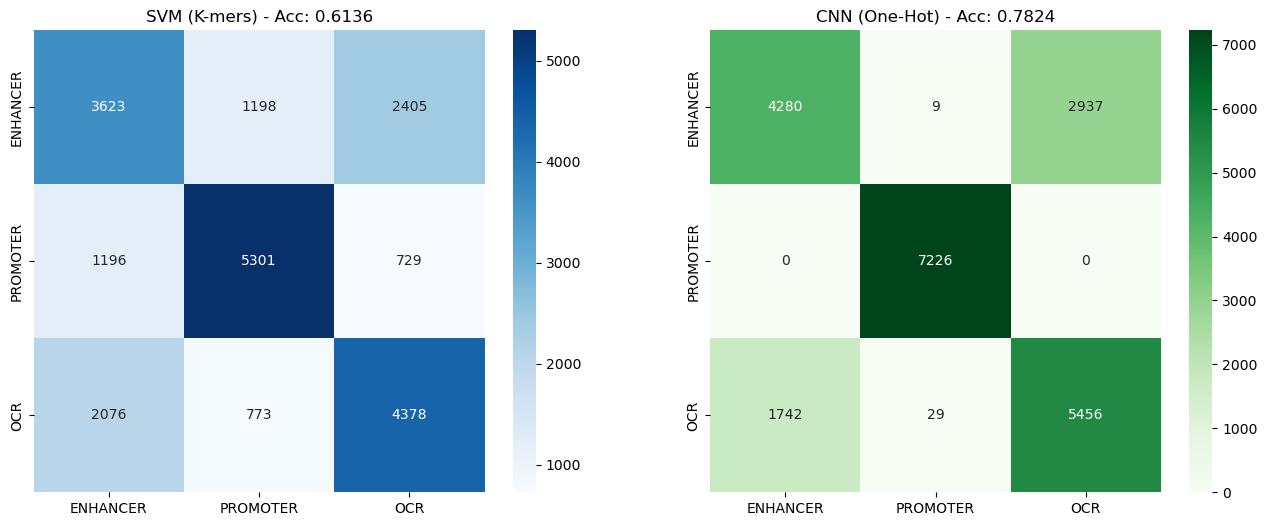


--- Detailed Report (CNN) ---
              precision    recall  f1-score   support

    ENHANCER       0.71      0.59      0.65      7226
    PROMOTER       0.99      1.00      1.00      7226
         OCR       0.65      0.75      0.70      7227

    accuracy                           0.78     21679
   macro avg       0.79      0.78      0.78     21679
weighted avg       0.79      0.78      0.78     21679



In [17]:
print("\n--- Step 4: Final Evaluation ---")

# קבלת התחזיות מהרשת
y_pred_cnn_probs = model.predict(X_test_cnn_ohe)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)
acc_cnn = accuracy_score(y_test, y_pred_cnn)

# גרף Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('CNN Loss')
plt.legend()

# גרף Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('CNN Accuracy')
plt.legend()
plt.show()

# מטריצות בלבול (Confusion Matrices)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
labels = [LABEL_MAP[i] for i in range(3)]

# SVM Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'SVM (K-mers) - Acc: {acc_svm:.4f}')

# CNN Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'CNN (One-Hot) - Acc: {acc_cnn:.4f}')

plt.show()

# הדפסת דוח מפורט
print("\n--- Detailed Report (CNN) ---")
print(classification_report(y_test, y_pred_cnn, target_names=labels))

In [18]:
model.save('dna_cnn_model_no_regulatory.keras')